In [1]:
'''In this version, infected compartments of movers are considered in the force of infection in the destination location.'''
import numpy as np
import matplotlib.pyplot as plt

#set seed to always get the same random numbers
np.random.seed(2)

'''
gen_population function takes the number of locations n and generate a numpy array 
of n integers representing the population of each location. 
The population of each location is a random number between 5000 and 10000. 
The function returns the numpy array of population. 
'''
def gen_population(n):
    return np.random.randint(5_000_000, 10_000_000, n)

'''gen_movement function takes the population of n locations 
and generate a numpy array of n by n integers representing the movement of people from each location.
Movemvent should be a random number between 3 to 8 percent of the total population of the location.
Note that the movement happens from column to row.
'''
def gen_movement(population,min=0.03, max=0.08, Mov=1, Chain=1):
    movement = np.zeros((len(population), len(population)))
    if Mov==1:
        for i in range(len(population)):
            for j in range(len(population)):
                movement[i][j] = np.random.randint(min * population[j], max * population[j])
        np.fill_diagonal(movement, 0)
        #if Chain==1, only allow movement from i to i+1, everything else is 0
    if Chain==1:
        movement = np.zeros((len(population), len(population)))
        for i in range(1,len(population)):
            movement[i][i-1] = np.random.randint(min * population[i-1], max * population[i-1])

    return movement


'''gen_mov_ratio function takes the movement matrix and divide each column by the popultaion 
to generate a numpy array of n by n floats'''
def gen_mov_ratio(movement, population):
    return movement@np.linalg.inv(np.diag(population))

'''test if the functions are working correctly'''
n=4
population = gen_population(n)
print(population)
movement = gen_movement(population, Chain=1)
print(movement)
mov_ratio = gen_mov_ratio(movement, population)
print(mov_ratio)

[6924264 7300397 8583510 6997099]
[[     0.      0.      0.      0.]
 [229145.      0.      0.      0.]
 [     0. 337846.      0.      0.]
 [     0.      0. 501576.      0.]]
[[0.         0.         0.         0.        ]
 [0.03309305 0.         0.         0.        ]
 [0.         0.04627776 0.         0.        ]
 [0.         0.         0.05843484 0.        ]]


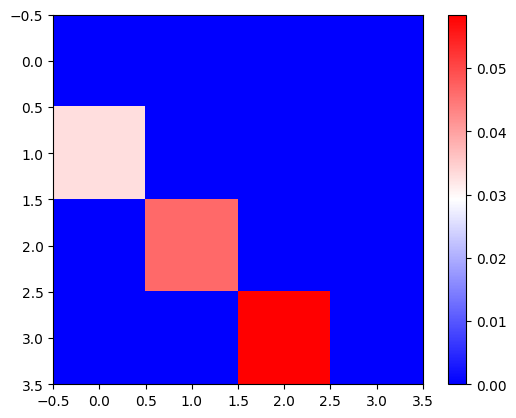

In [2]:
#plot movement matrix as a heatmap
#add heat scale values
#do not scale the values
#let the largest value be dark red and the smallest value be dark blue
plt.imshow(mov_ratio, cmap='bwr', interpolation='nearest')
plt.colorbar()
plt.show()

[[6.924264e+06 5.000000e+00 0.000000e+00]
 [7.300397e+06 0.000000e+00 0.000000e+00]
 [8.583510e+06 0.000000e+00 0.000000e+00]
 [6.997099e+06 0.000000e+00 0.000000e+00]]


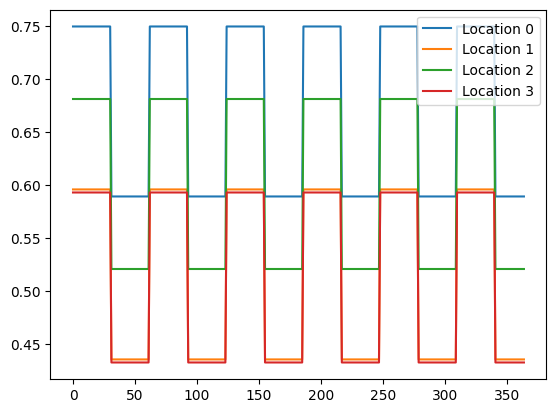

In [3]:
'''gen_initial_cond function takes the population of n locations and generate a numpy array
of n times 3 intergers representing the initial condition of SIR model for each location.
The initial condition for I is a random number between 0 and 1.
or 0.01 to 0.03 of the total population of the location.
'''
def gen_initial_cond(population):
    n = len(population)
    #I = np.random.randint(0.01*population, 0.03*population)
    I = 0 * np.random.randint(0,5,n)
    S = population - I
    R= np.zeros(n)
    #return transpose of the array
    return np.array([S,I,R]).T


'''test if the function is working correctly'''
initial_cond = gen_initial_cond(population)
initial_cond[0,1] = 5
print(initial_cond)

'''gen_beta function generates a numpy array of n by t floats representing the transmission rate in each pair of locations.
The transmission rate has a seasonality pattern that is a normal distribution 
center at a random number between 0.1 and 0.3, variance 0.01, and cosine seasonality function that has period 365 days.'''
def gen_beta(n, t):
    beta_mean = np.random.uniform(0.6, 0.8, n)
    #for each mean, generate a random normal distribution with variance 0.01
    #combine the seasonality pattern with the random normal distribution
    beta = np.array([beta_mean[i] + 0.1*np.cos(4*np.pi*np.arange(t)/365) for i in range(n)])
    #inject some noise to beta
    #comment the following line to remove noise if needed
    #beta += np.random.normal(0, 0.01, (n,t))
    return beta


def switch_beta_value(current_value: float, high_value: float, low_value: float) -> float:
    """
    Helper function for gen_step_beta()
    Switches the beta value from high to low or vice versa.
    """
    return low_value if current_value == high_value else high_value


def gen_step_beta(n: int, t: int, period: int = 31) -> np.ndarray:
    """
    Generate a step-function beta.
    Switches value at each period.
    """
    # beta varies by location
    beta_mean = np.random.uniform(0.5, 0.7, n)
    
    beta = np.zeros((n, t))
    
    for i in range(n):
        # high value as the infection is ramping up
        high_value = beta_mean[i] + 0.08
        # low value as the infection dies down
        low_value = beta_mean[i] - 0.08
        
        current_value = high_value
        for day in range(t):
            if day % period == 0 and day != 0:
                current_value = switch_beta_value(current_value, high_value, low_value)
            beta[i, day] = current_value
            
    return beta


step_beta = gen_step_beta(n, 365)
for i in range(n):
    plt.plot(step_beta[i], label='Location ' + str(i))
plt.legend()


real_beta = step_beta


In [4]:
'''We start each time step by running the tau leaping algorithm on our
day time population. The day time tau leap is moving compartments to different locations.
We assume that the time clock starts at 8am in the morning. We run the tau leap for 1/3 of the day, 
and then we run the night time tau leap for 2/3 of the day.'''
tau_day = 1 / 3 # Time step for daytime tau leap
tau_night = 2 / 3 # Time step for night time tau leap   
def SIR_tau_leap(population, movement, initial_cond, beta):

    n = len(population)
    #initialize the result array
    result = np.zeros((n,3,2))
    result[:,:,0] = initial_cond    
    mov_ratio = gen_mov_ratio(movement, population)

    #start the tau leap for the day time
    #separate the movers in S,I,R compartments with movement matrix
    #simulate the transmission among movers
    #first compute the in movement of people in each compartment
    mov_S = mov_ratio@np.diag(result[:,0,0])
    mov_I = mov_ratio@np.diag(result[:,1,0])
    #compute the beta for each location at time i

    #then compute the transmitted people from S to I
    #with the transmission rate being beta_i, which is the destination of the movement
    #movement is the total population movement
    mov_SI=np.divide(np.multiply(mov_I,mov_S),movement)
    mov_SI[~np.isfinite(mov_SI)] = 0
    #make the diagonal of the matrix 0
    mov_SI[range(n), range(n)] = 0
    #tau leap for the day time movement infection force

    transfer_SI = np.random.poisson(np.diag(beta)@mov_SI*tau_day)

    #update the S,I,R compartments with the local transmission rate
    #extract the S,I,R compartments
    #subtract the movers
    #last term mov_ratio@result[:,0,i-1] records the number of sus/infected people that are moving in the destination location
    S = result[:,0,0]-np.sum(mov_S, axis=0).T + mov_ratio@result[:,0,0] 
    I = result[:,1,0]-np.sum(mov_I, axis=0).T + mov_ratio@result[:,1,0] 
    R = result[:,2,0]
    
    #generate a poisson random number for each time step
    force_of_infection = np.random.poisson(tau_day*beta*S*I/population)
    result[:,0,1] = S - force_of_infection
    #recover rate is 0.2 per day
    force_of_recovery = np.random.poisson(0.2*I*tau_day)
    result[:,1,1] = I + force_of_infection - force_of_recovery
    result[:,2,1] = R + force_of_recovery

    #start the tau leap for the night time
    #add the newly infected people back to their home location
    result[:,0,1]=result[:,0,1]+np.sum(mov_S, axis=0).T - np.sum(transfer_SI, axis=0).T - mov_ratio@result[:,0,0] 
    result[:,1,1]=result[:,1,1]+np.sum(mov_I, axis=0).T + np.sum(transfer_SI, axis=0).T - mov_ratio@result[:,1,0] 
    #find the negative values in ressult[:,1,i]
    #The reason for the negative values is that the force of infection is too high
    #find the index of the negative values in S
    neg_index_S = np.where(result[:,0,1]<0)
    #if neg_index_S is not empty
    if neg_index_S[0].size != 0:
        #save the negative values
        neg_value_S = result[neg_index_S,0,1]
        #set the negative values to 0
        result[neg_index_S,0,1] = 0
        #add the negative values to the infected compartment
        result[neg_index_S,1,1] = result[neg_index_S,1,1] + neg_value_S

    #find the index of the negative values in I 
    neg_index_I = np.where(result[:,1,1] < 0)
    #if neg_index is not empty
    if neg_index_I[0].size != 0: 

        #save the negative values
        neg_valu_I = result[neg_index_I,1,1]
        #set the negative values to 0
        result[neg_index_I,1,1] = 0
        #add the negative values to the recovered compartment
        result[neg_index_I,2,1] = result[neg_index_I,2,1] + neg_valu_I 
    #update the S,I,R compartments with the local transmission rate
    #extract the S,I,R compartments
    S = result[:,0,1]
    I = result[:,1,1]
    R = result[:,2,1]
    #generate a poisson random number for each time step
    force_of_infection = np.random.poisson(tau_night*beta*S*I/population)
    result[:,0,1] = S - force_of_infection
    #recover rate is 0.2 per day
    force_of_recovery = np.random.poisson(0.2*I*tau_night)
    result[:,1,1] = I + force_of_infection - force_of_recovery
    result[:,2,1] = R + force_of_recovery

    #find the negative values in result[:,1,i]
    #The reason for the negative values is that the force of infection is too high
    #find the index of the negative values in S
    neg_index_S = np.where(result[:,0,1]<0)
    #if neg_index_S is not empty
    if neg_index_S[0].size != 0:
        #save the negative values
        neg_value_S = result[neg_index_S,0,1]
        #set the negative values to 0
        result[neg_index_S,0,1] = 0
        #add the negative values to the infected compartment
        result[neg_index_S,1,1] = result[neg_index_S,1,1] + neg_value_S

    #find the index of the negative values in I 
    neg_index_I = np.where(result[:,1,1]<0)
    #if neg_index is not empty
    if neg_index_I[0].size != 0: 

        #save the negative values
        neg_valu_I = result[neg_index_I,1,1]
        #set the negative values to 0
        result[neg_index_I,1,1] = 0
        #add the negative values to the recovered compartment
        result[neg_index_I,2,1] = result[neg_index_I,2,1] + neg_valu_I 
    
    #sum the compartments to check if the total population is conserved
    #return nothing for now
    #the first dimension of the result is the location
    #the second dimension is the S,I,R compartments
    #the third dimension is the time step, it has two values, 0 for the beginning of the day, 1 for the end of the day
    
    return result

'''test if the function is working correctly'''
days = 60
results = np.zeros((days, n, 3))
results[0,:,:] = initial_cond
#first dimention of results is the time step
#second dimention is the location
#third dimention is the S,I,R compartments
for t in range(1, days):
    results[t:,:] = SIR_tau_leap(population, movement, results[t-1,:,:], real_beta[:,t])[:,:,-1]




/tmp/ipykernel_420895/4219373756.py:26: RuntimeWarning: invalid value encountered in divide
  mov_SI=np.divide(np.multiply(mov_I,mov_S),movement)


Text(0.5, 1.0, 'Infected compartments for all locations')

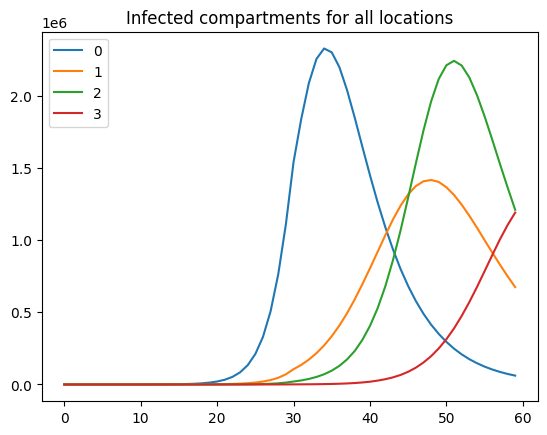

In [5]:
#plot infected compartments for all locations together in one plot
plt.plot(results[:,:,1])
#add legend to the plot
plt.legend(range(n))
#add title to the plot
plt.title('Infected compartments for all locations')

Text(0.5, 1.0, 'Susceptible compartments for all locations')

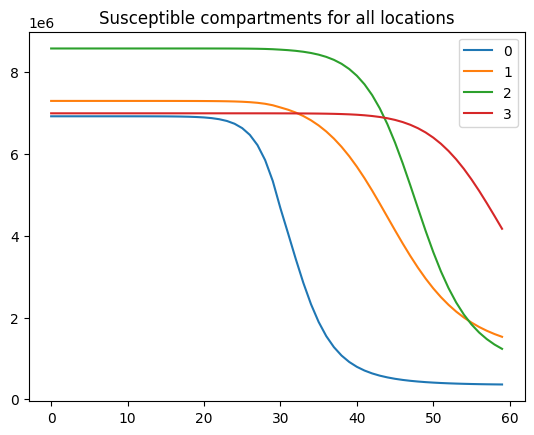

In [6]:
#plot susceptible compartments for all locations together in one plot
plt.plot(results[:,:,0])
#add legend to the plot
plt.legend(range(n))
#add title to the plot
plt.title('Susceptible compartments for all locations')

In [7]:
def jacob(δ):
    """The jacobian logarithm, used in log likelihood normalization and resampling processes
    δ will be an array of values. 
    
    Args: 
        δ: An array of values to sum

    Returns: 
        The vector of partial sums of δ.           
    """
    n = len(δ)
    Δ = np.zeros(n)
    Δ[0] = δ[0]
    for i in range(1,n):
        Δ[i] = max(δ[i],Δ[i-1]) + np.log(1 + np.exp(-1*np.abs(δ[i] - Δ[i-1])))
    return(Δ)


def log_norm(log_weights):
    """normalizes the probability space using the jacobian logarithm as defined in jacob()"""
    norm = (jacob(log_weights)[-1])
    log_weights -= norm
    return log_weights

In [8]:
'''Log Domain Particle Filter'''
from scipy.stats import poisson,norm

#data is 
data = results[:,:,1]

'''The following lines until the next code block are all set up for the algorithm.'''
num_particles = 1000
particles = []
betas = []
weights = np.zeros(num_particles)

m_post = np.zeros((results[:,:,1].shape[0],n,3))
beta_post = np.zeros((results[:,:,1].shape[0],n))

for _ in range(num_particles):
    particle = np.zeros((n,3,results[:,:,1].shape[0])) #Initialize a particle of shape (n,3)
    for loc in range(0,n):
        I = np.random.randint(0,5) #Random infection seed
        S = population[loc] - I
        R = 0

        particle[loc,:,0] = S,I,R #Population the IC at loc

    particles.append(particle)

    
for _ in range(num_particles):
    beta = np.zeros((n,results[:,:,1].shape[0])) #Initialize a particle of shape (n,3)
    for loc in range(0,n):
        beta[loc,0] = np.random.uniform(0.6,0.8)
    betas.append(beta)


particles = np.array(particles) # NumPy operations will make this more efficient, (num_particles,n,3)
betas = np.array(betas)


'''Run the particle Filter'''
for t in range(results.shape[0]): 

    print(f"Iteration: {t} \r")
    #Forward step, run the tau leap algorithm
    if(t != 0):
        for index in range(num_particles): 
            particles[index,:,:,t] = SIR_tau_leap(population, movement,particles[index,:,:,t-1], betas[index,:,t-1])[:,:,-1]
            betas[index,:,t] = betas[index,:,t-1]
    
    #Calculate the weights
    weights = np.zeros(num_particles)

    for index in range(num_particles): 
        for loc in range(n):
            weights[index] += norm.logpdf(data[t,loc],particles[index,loc,1,t],100_000)

    weights = log_norm(weights)

    log_cdf = jacob(weights)
    
    i = 0
    resampling_indices = np.zeros(num_particles).astype(int)
    u = np.random.uniform(0,1/num_particles)
    #The resampling algorithm in the log domain
    for j in range(0,num_particles): 
        r = np.log(u + 1/num_particles * j)
        while r > log_cdf[i]: 
            i += 1
        resampling_indices[j] = i

    #Resample the particles
    particles_copy = np.copy(particles[:,:,:,t])
    particles[:,:,:,t] = particles_copy[resampling_indices,:,:]

    #Resample the parameters
    betas_copy = np.copy(betas[:,:,t])
    betas[:,:,t] = betas_copy[resampling_indices,:]

    #Perturbation
    for index in range(num_particles): 
        betas[index,:,t] = np.exp(np.random.multivariate_normal(np.log(betas[index,:,t]),0.001 * np.eye(n)))


    #m_post[t,:,:] = np.mean(particles[:,:,:,t],axis = 0)
    beta_post[t,:] = np.average(betas[:,:,t],axis = 0,weights = weights)
    m_post[t,:,:] = np.average(particles[:,:,:,t],axis = 0,weights = weights)

beta_post_log=beta_post
m_post_log=m_post




Iteration: 0 
Iteration: 1 


/tmp/ipykernel_420895/4219373756.py:26: RuntimeWarning: invalid value encountered in divide
  mov_SI=np.divide(np.multiply(mov_I,mov_S),movement)


Iteration: 2 
Iteration: 3 
Iteration: 4 
Iteration: 5 
Iteration: 6 
Iteration: 7 
Iteration: 8 
Iteration: 9 
Iteration: 10 
Iteration: 11 
Iteration: 12 
Iteration: 13 
Iteration: 14 
Iteration: 15 
Iteration: 16 
Iteration: 17 
Iteration: 18 
Iteration: 19 
Iteration: 20 
Iteration: 21 
Iteration: 22 
Iteration: 23 
Iteration: 24 
Iteration: 25 
Iteration: 26 
Iteration: 27 
Iteration: 28 
Iteration: 29 
Iteration: 30 
Iteration: 31 
Iteration: 32 
Iteration: 33 
Iteration: 34 
Iteration: 35 
Iteration: 36 
Iteration: 37 
Iteration: 38 
Iteration: 39 
Iteration: 40 
Iteration: 41 
Iteration: 42 
Iteration: 43 
Iteration: 44 
Iteration: 45 
Iteration: 46 
Iteration: 47 
Iteration: 48 
Iteration: 49 
Iteration: 50 
Iteration: 51 
Iteration: 52 
Iteration: 53 
Iteration: 54 
Iteration: 55 
Iteration: 56 
Iteration: 57 
Iteration: 58 
Iteration: 59 


[[ 78016.20677837  57413.61470288  66786.79208635]
 [143529.58802823  27635.4562902  141976.14940382]
 [ 78825.20010171  26303.86725397  74288.05476044]
 [534582.42467207 199402.61070407 428568.81498249]]


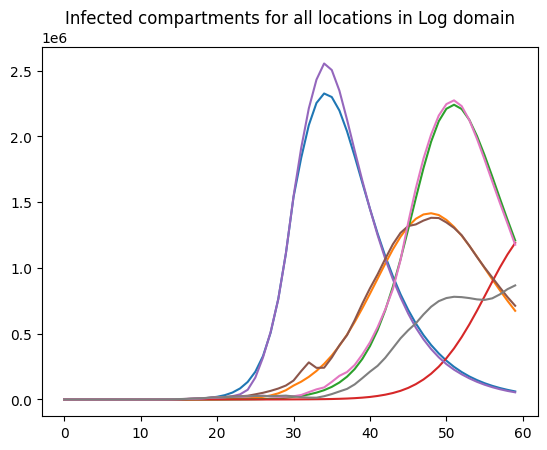

In [9]:
        
plt.plot(data)

plt.plot(m_post_log[:,:,1],alpha=1)
#add a title to the plot
plt.title('Infected compartments for all locations in Log domain')

rmse_log = np.sqrt(np.mean((results - m_post_log)**2,axis = 0))
print(rmse_log)

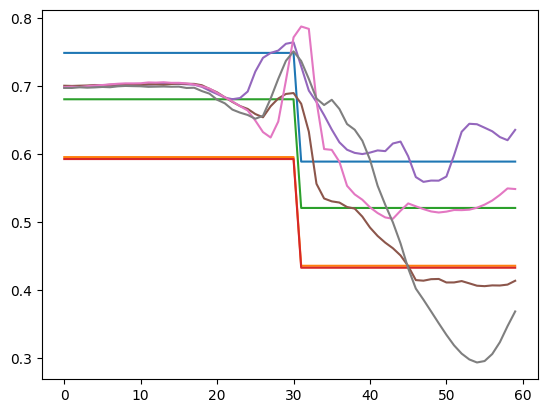

In [10]:
for i in range(n):
    plt.plot(real_beta[i,:days])

plt.plot(beta_post_log)

In [11]:
'''lin Domain Particle Filter'''
from scipy.stats import poisson,norm

data = results[:,:,1]

'''The following lines until the next code block are all set up for the algorithm.'''
num_particles = 1000
particles = []
betas = []
weights = np.zeros(num_particles)

m_post = np.zeros((results[:,:,1].shape[0],n,3))
beta_post = np.zeros((results[:,:,1].shape[0],n))

for _ in range(num_particles):
    particle = np.zeros((n,3,results[:,:,1].shape[0])) #Initialize a particle of shape (n,3)
    for loc in range(0,n):
        I = np.random.randint(0,5) #Random infection seed
        S = population[loc] - I
        R = 0

        particle[loc,:,0] = S,I,R #Population the IC at loc

    particles.append(particle)

    
for _ in range(num_particles):
    beta = np.zeros((n,results[:,:,1].shape[0])) #Initialize a particle of shape (n,3)
    for loc in range(0,n):
        beta[loc,0] = np.random.uniform(0.6,0.8)
    betas.append(beta)


particles = np.array(particles) #NumPy operations will make this more efficient, (num_particles,n,3)
betas = np.array(betas)


'''Run the particle Filter'''
for t in range(results.shape[0]): 

    print(f"Iteration: {t}")

    if(t != 0):
        for index in range(num_particles): 
            particles[index,:,:,t] = SIR_tau_leap(population, movement,particles[index,:,:,t-1], betas[index,:,t-1])[:,:,-1]
            betas[index,:,t] = betas[index,:,t-1]

    weights = np.ones(num_particles)

    for index in range(num_particles): 
        for loc in range(n):
            weights[index] *= norm.pdf(data[t,loc],particles[index,loc,1,t],100_000)

    weights /= np.sum(weights)

    cdf = np.cumsum(weights)
    
    i = 0
    resampling_indices = np.zeros(num_particles).astype(int)
    u = np.random.uniform(0,1/num_particles)
    #The resampling algorithm in the lin domain
    for j in range(0,num_particles): 
        r = (u + 1/num_particles * j)
        while r > cdf[i]: 
            i += 1
        resampling_indices[j] = i

    #Resample the particles
    particles_copy = np.copy(particles[:,:,:,t])
    particles[:,:,:,t] = particles_copy[resampling_indices,:,:]

    #Resample the parameters
    betas_copy = np.copy(betas[:,:,t])
    betas[:,:,t] = betas_copy[resampling_indices,:]

    #Perturbation
    for index in range(num_particles): 
        betas[index,:,t] = np.exp(np.random.multivariate_normal(np.log(betas[index,:,t]),0.001 * np.eye(n)))


    #m_post[t,:,:] = np.mean(particles[:,:,:,t],axis = 0)
    beta_post[t,:] = np.average(betas[:,:,t],axis = 0,weights = weights)
    m_post[t,:,:] = np.average(particles[:,:,:,t],axis = 0,weights = weights)

beta_post_lin=beta_post
m_post_lin=m_post



Iteration: 0
Iteration: 1


/tmp/ipykernel_420895/4219373756.py:26: RuntimeWarning: invalid value encountered in divide
  mov_SI=np.divide(np.multiply(mov_I,mov_S),movement)


Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59


In [12]:
betas[:,1,0]

array([0.64677553, 0.80532908, 0.58583668, 0.80694953, 0.69785696,
       0.72950318, 0.77147613, 0.69762797, 0.76661486, 0.65813096,
       0.68615413, 0.59752636, 0.7566015 , 0.68377719, 0.64055915,
       0.68893521, 0.71509518, 0.70423908, 0.6085609 , 0.63380831,
       0.67320704, 0.74466933, 0.75063909, 0.61335878, 0.66102087,
       0.72259675, 0.67885326, 0.82335796, 0.69378768, 0.8074564 ,
       0.68966555, 0.68389821, 0.63518724, 0.6638489 , 0.60068458,
       0.70232715, 0.62124259, 0.63524305, 0.6615518 , 0.62949842,
       0.71046104, 0.82617598, 0.65448899, 0.7359835 , 0.66327215,
       0.7778842 , 0.60819842, 0.66532262, 0.70461593, 0.73118906,
       0.66434635, 0.66622052, 0.7020209 , 0.77638599, 0.64938133,
       0.63072622, 0.59499273, 0.74705711, 0.82390599, 0.71589624,
       0.70349484, 0.78994185, 0.75846244, 0.74122692, 0.68282024,
       0.62346559, 0.63017994, 0.68712253, 0.80414885, 0.65293329,
       0.6809033 , 0.60474259, 0.75736021, 0.66945152, 0.72756

[1188650.61202446  484848.24030124  959372.29583311]
[834953.41958038 310755.54895112 711619.81123309]


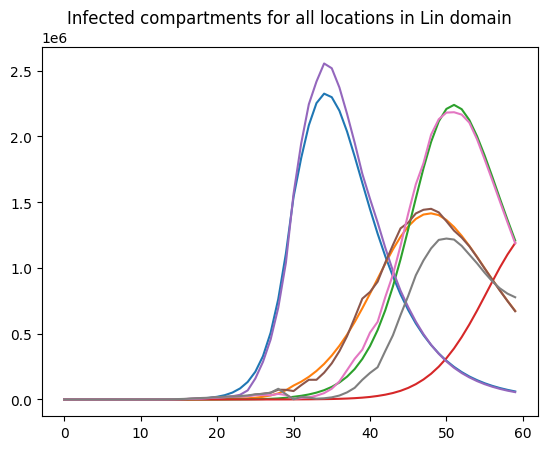

In [13]:

plt.plot(data)
plt.plot(m_post_lin[:,:,1],alpha=1)
#add a title to the plot
plt.title('Infected compartments for all locations in Lin domain')
#compute root mean square error
rmse_lin = np.sqrt(np.mean((results - m_post_lin)**2,axis = 0))
print(np.sum(rmse_lin, axis = 0))
print(np.sum(rmse_log, axis = 0))


In [14]:
slin=np.sum(rmse_lin, axis = 0)
slog=np.sum(rmse_log, axis = 0)
slog-slin

array([-353697.19244408, -174092.69135012, -247752.48460001])

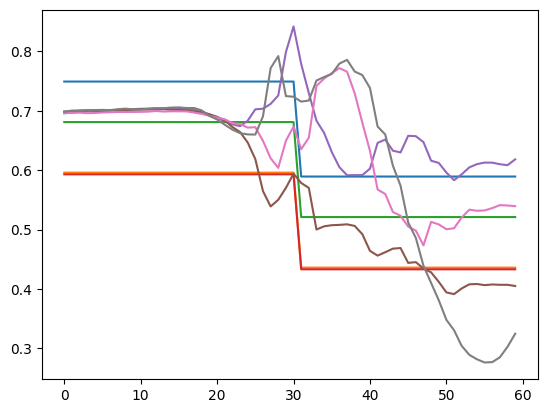

In [15]:
for i in range(n):
    plt.plot(real_beta[i,:days])
    
plt.plot(beta_post_lin)